In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import final_func as fn
from sklearn.utils import resample
from scipy.stats import mannwhitneyu

In [2]:
# Load data
result = pd.read_csv("data/results.csv")
lap = pd.read_csv("data/lap_times.csv")

In [3]:
lap

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342
...,...,...,...,...,...,...
517568,1076,848,54,7,1:22.589,82589
517569,1076,848,55,7,1:22.758,82758
517570,1076,848,56,7,1:22.658,82658
517571,1076,848,57,9,1:38.438,98438


In [2]:
def data_process(df: pd.DataFrame, lap_df: pd.DataFrame) -> pd.DataFrame:
    # df.rename(columns = {'position':'final position'}, inplace = True)
    position_df = df[["raceId", "driverId", "positionOrder"]]
    joined_table = lap.merge(position_df, on=["raceId", "driverId"], how="left")
    joined_table["time"] = joined_table["time"].str.split(':')
    # new df from the column of lists
    split_df = pd.DataFrame(joined_table["time"].tolist(), columns=['lap_minutes', 'lap_seconds', 'none'])
    # concat df and split_df
    joined_table = pd.concat([joined_table, split_df], axis=1)
    joined_table["positionOrder"] = joined_table["positionOrder"].astype(int)
    joined_table["lap_minutes"] = joined_table["lap_minutes"].astype(int)
    joined_table["lap_second"] = joined_table["lap_minutes"].astype(float)
    #since most of the time spend for each lap is below 5 minutes, we assumed that the time spent greater than 5 minutes should be caused by accidents rather than strategy. Thus, we focus on lap with time spend less than 6 minutes.
    li = [1, 2, 3, 4, 5]
    df_filtered = joined_table[joined_table['lap_minutes'].isin(li)]
    df_filtered["lap_time"] = " "
    sec = []
    for time_list in df_filtered["time"]:
        if time_list[0] == "1":
            second = 60 + float(time_list[1])
            sec.append(second)
        elif time_list[0] == "2":
            second = 120 + float(time_list[1])
            sec.append(second)
        elif time_list[0] == "3":
            second = 180 + float(time_list[1])
            sec.append(second)
        elif time_list[0] == "4":
            second = 240 + float(time_list[1])
            sec.append(second)
        elif time_list[0] == "5":
            second = 300 + float(time_list[1])
            sec.append(second)
    df_filtered["lap_time"] = sec
    df_group = df_filtered.groupby(["raceId", "driverId", 'positionOrder'], as_index=False)["lap_time"].std()
    # df_group = df_filtered.groupby(['positionOrder'], as_index=False)["lap_time"].std()
    df_group.sort_values(by=['positionOrder'], inplace=True)
    df_group.rename(columns={'lap_time': 'lap_time_STD'}, inplace=True)
    return df_group


In [3]:

def barchart_lapspeed(df: pd.DataFrame) -> plt:
    df2 = df.groupby(['positionOrder'], as_index=False)["lap_time_STD"].mean()
    df2.plot.bar(x='positionOrder', y='lap_time_STD', fontsize='9')
    plt.xlabel('Position', fontsize='12', rotation=1)
    plt.ylabel('Mean of lap time STD', fontsize='12')
    plt.xticks(rotation=1)
    plt.title('Distribution of lap time by rank', fontsize='12')
    plt.show()



In [4]:
# Process the data files
df_group = data_process(result, lap)
barchart_lapspeed(df_group)

NameError: name 'data_process' is not defined

In [5]:
item = 0
print((item-1)//5 +1)

0


In [11]:
def lap_data_process(df: pd.DataFrame, lap_df: pd.DataFrame) -> pd.DataFrame:
    position_df = df[["raceId", "driverId", "positionOrder"]]
    joined_table = lap_df.merge(position_df, on=["raceId", "driverId"], how="left")
    joined_table["milliseconds"] = joined_table["milliseconds"].astype(int)
    # since most of the time spend for each lap is below 5 minutes, we assumed that the time spent greater than 5
    # minutes should be caused by accidents rather than strategy. Thus, we focus on lap with time spend less than 6
    # minutes.
    joined_table= joined_table.loc[joined_table['milliseconds']<=360000]
    joined_table['lap_second']= joined_table['milliseconds'] /1000
    df_group = joined_table.groupby(["raceId", "driverId", 'positionOrder'], as_index=False)['lap_second'].std()
    df_group.sort_values(by=['raceId', 'positionOrder'], inplace=True)
    df_group.rename(columns={'lap_second': 'lap_time_STD'}, inplace=True)
    return df_group

In [12]:
lap_df =lap_data_process(result, lap)
lap_df

,raceId,driverId,positionOrder,lap_time_STD
14,1,18,1,21.739206
17,1,22,2,16.828341
11,1,15,3,16.254860
8,1,10,4,16.013240
3,1,4,5,16.337007
...,...,...,...,...
9770,1076,849,16,15.691930
9755,1076,4,17,18.466064
9761,1076,830,18,22.873014
9756,1076,20,19,16.703554


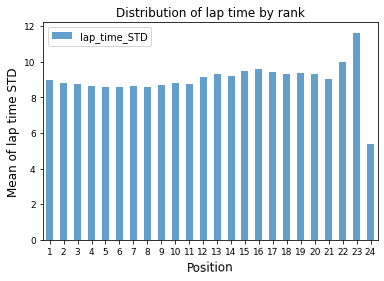

In [13]:
fn.barchart_lapspeed(lap_df)

In [81]:
def rank_df_plt(df: pd.DataFrame, top_num = 5, threshold = 0.05):
    print('H0: There is no significant difference in the distribution of lap times STD between the ranking of drivers.')
    rank_list = []
    df = df.assign(rank='')
    position_list = df['positionOrder'].tolist()

    for position in position_list:
        if position <= top_num:
            rank_list.append('High Rank')
        else:
            rank_list.append('Low Rank')

    df['rank'] = rank_list
    df_high = df.loc[df['rank'] == 'High Rank']['lap_time_STD']
    df_low = resample(df.loc[df['rank'] == 'High Rank']['lap_time_STD'], replace=True, n_samples=len(df_high), random_state=123)
    bins = np.linspace(0, 40, 20)
    color_bin = ['tab:blue', 'tab:orange', 'tab:red']
    plt.hist(df_low, bins, alpha=0.8, color=color_bin[2], label='Lower Ranking')
    plt.hist(df_high, bins, alpha=0.8, color=color_bin[0], label='Higher Ranking')
    plt.title(f'Frequency Distribution of Lap time STD')
    plt.ylabel('Record Frequency')
    plt.xlabel('Lap time STD')
    plt.legend(loc="upper right")
    plt.show()
    pvalue = mannwhitneyu(df_high,df_low).pvalue
    print('-' * 88)
    print('P-value between high ranking drivers and low ranking drivers is {}.'.format(pvalue))
    print('-' * 88)
    if pvalue < threshold:
        print("Reject H0.", "There is a difference.")
    else:
        print("H0 cannot be rejected")

H0: There is no significant difference in the distribution of lap times STD between the ranking of drivers.


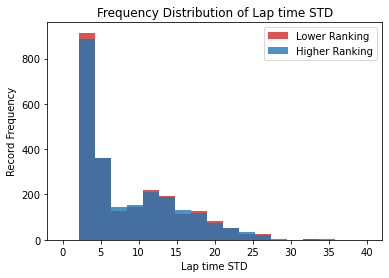

----------------------------------------------------------------------------------------
P-value between high ranking drivers and low ranking drivers is 0.30846789394625385.
----------------------------------------------------------------------------------------
H0 cannot be rejected


In [82]:
rank_df_plt(lap_df)